# Q-Learning experiment runner

## Imports

In [1]:
%%capture
!pip install tqdm

In [16]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

from tqdm import tqdm
import numpy as np
import pandas as pd
import os
from operator import itemgetter
from contextlib import redirect_stdout
from datetime import datetime

from typing import Tuple, Any

In [3]:
from q_maze import QMaze, Action
from e_greedy_policy import EGreedyPolicy
from qlearning import QLearning

from qlearning_exp_functions import Results, train_ql_for_one_episode, run_ql_experiments
from utils import stringify_dict, preprocess_hyperparameters_filename

## Smoke test for QMaze, EGreedyPolicy and running on one episode

In [10]:
qm = QMaze(10)
# Reminder that QMaze.reset only returns agent state now.
# Be careful to capture the state when resetting, because the 
# Agent/entrance will move!
state = qm.reset()
eg_policy = EGreedyPolicy(epsilon=0.5, decay=0.9)
ql = QLearning(policy=eg_policy, environment=qm, gamma=0.9, alpha=0.01)


In [11]:
qm.display(debug=True)

X X X X X X X X X X 
X . . X A . X X . X 
X X . X X . . . . X 
X . . . X X X . X X 
X X X . X . X . . X 
X . . . X . . . X X 
X X X . X X X . . X 
X . . . . . X . X X 
X . X . X . . . . X 
X X X X X X X X O X 

{'maze_width': 10, 'maze_height': 10, 'size': 10, 'has_treasure': False, 'treasure_found': 0, 'treasure_left': 0, 'treasure_map': [], 'position_agent': (1, 4), 'position_entrance': (1, 4), 'position_exit': (9, 8), 'maze': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 1, 2, 0, 1, 1, 0, 1],
       [1, 1, 0, 1, 1, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 1, 1, 1, 0, 1, 1],
       [1, 1, 1, 0, 1, 0, 1, 0, 0, 1],
       [1, 0, 0, 0, 1, 0, 0, 0, 1, 1],
       [1, 1, 1, 0, 1, 1, 1, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 0, 1, 1],
       [1, 0, 1, 0, 1, 0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 3, 1]]), 'generation_start_coords': (8, 7), 'generation_start_neighbours': [], 'turns_elapsed': 0, 'done': False, 'coord_to_index_state': array([[27, 46, 95, 50, 74, 84, 90,  0, 37, 97

### One iteration to check policy is working with QLearning

113
-480


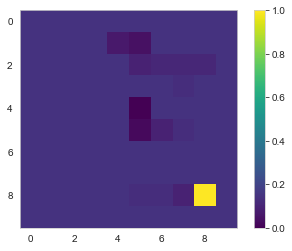

In [12]:
done = False
total_reward = 0

while not done:
    next_action = eg_policy(state, ql.q_value_store)
    next_state, reward, done = qm.step(next_action)
    next_action_index = next_action.value.index
    
    ql.update_q_values(
        current_state=state,
        next_action=next_action_index,
        next_reward=reward,
        next_state=next_state
    )

    eg_policy.update_epsilon()
    state = next_state
    total_reward += reward

print(qm.turns_elapsed)
print(total_reward)
vals = ql.display_q_values()
plt.imshow((vals - vals.min())/(vals.max() - vals.min()), cmap="viridis")
plt.colorbar()
plt.grid(False)
plt.show();

In [15]:
# The maze is solved
qm.display()

X X X X X X X X X X 
X . . X I . X X . X 
X X . X X . . . . X 
X . . . X X X . X X 
X X X . X . X . . X 
X . . . X . . . X X 
X X X . X X X . . X 
X . . . . . X . X X 
X . X . X . . . . X 
X X X X X X X X A X 



## Run for more episodes

Parameterise:
- epsilon for e-greedy
- gamma - discount factor
- alpha - learning rate or memory
- size of maze
- max reward
- decay - constant decay of epsilon

In [4]:
# Some plotting functions which must live here
# because of notebook functionality.
def plot_mean_rewards_episodes(episode_idx: int, experiment_mean_rewards: list):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title(f"Last mean reward of {experiment_mean_rewards[-1]} after {episode_idx} episodes")
    plt.xlabel("Per 100 episodes")
    plt.ylabel("Mean reward")
    plt.plot(experiment_mean_rewards)
    plt.show()

def plot_turns_elapsed_episodes(episode_idx: int, experiment_mean_turns_elapsed: list):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title(f"Last turns elapsed of {experiment_mean_turns_elapsed[-1]} after {episode_idx} episodes")
    plt.xlabel("Per 100 episodes")
    plt.ylabel("Mean turns elapsed")
    plt.plot(experiment_mean_turns_elapsed)
    plt.show()

In [5]:
qm = QMaze(10)
eg_policy = EGreedyPolicy(epsilon=0.6, decay=0.9)
ql = QLearning(policy=eg_policy, environment=qm, gamma=0.9, alpha=0.01)

LOGGING_STEP_SIZE: int = 10
NUM_EPISODES: int = 1000
NUM_RUNS: int = 100
NUM_RUNS_TQDM = tqdm(range(NUM_RUNS))
NUM_LOGGED_EPISODES: int = 1000//LOGGING_STEP_SIZE

# Create structure to store data
all_results: list = []

# Plot rewards and turns elapsed
experiment_mean_rewards: list = []
experiment_mean_turns_elapsed: list = []

for run in NUM_RUNS_TQDM:
    if ((run % LOGGING_STEP_SIZE) == 0) or (run == 1):
        results = run_ql_experiments(environment=qm, policy=eg_policy, q_learning_method=ql, num_episodes=NUM_LOGGED_EPISODES)
        print(f"Run: {run}, ending epsilon: {eg_policy.epsilon}, mean reward: {results.mean_reward}, mean turns elapsed: {results.mean_turns_elapsed}, std reward: {results.var_reward}")
        all_results.append(results)
        experiment_mean_rewards.append(results.mean_reward)
        experiment_mean_turns_elapsed.append(results.mean_turns_elapsed)

        # Plot mean turns elapsed live
        plt.plot(experiment_mean_turns_elapsed);
        plt.title(f"Mean turns elapsed for {NUM_EPISODES} episodes");
        plt.xlabel(f"Per {NUM_LOGGED_EPISODES} episodes");
        plt.ylabel("Mean turns elapsed");
        plt.ylim([0, 1000]);
        plt.xlim([0, LOGGING_STEP_SIZE]);



  0%|          | 0/100 [00:00<?, ?it/s]


TypeError: run_ql_experiments() missing 1 required positional argument: 'hyperparameter_dict'

X X X X X X X X X X 
X X X . . . X A . X 
X X . . X . . . X X 
X . . X X X X . X X 
X X X X . . . . . X 
X . . . . X X . X X 
X X X X X X . . . X 
X X X X X X . X . X 
X . . . . . . X . X 
X X X X X X X X O X 



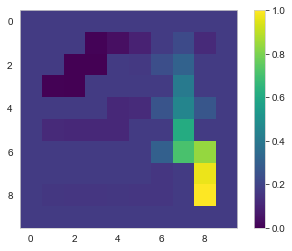

In [10]:
qm.reset()
qm.display()
results_vals = ql.display_q_values()
plt.imshow((results_vals - results_vals.min())/(results_vals.max() - results_vals.min()), cmap="viridis")
plt.colorbar()
plt.grid(False)
plt.show();


In [ ]:
# Plot rewards
plt.plot(experiment_mean_rewards);
plt.title(f"Mean rewards for {NUM_EPISODES} episodes");
plt.xlabel(f"Per {NUM_LOGGED_EPISODES} episodes");
plt.ylabel("Reward");
plt.ylim([-1000, 200]);
plt.xlim([0, LOGGING_STEP_SIZE]);

In [23]:
def train_on_qlearning(
    env_size: int,
    epsilon: float,
    decay: float,
    gamma: float,
    alpha: float,
    num_runs_tqdm: Any,
    logging_step_size: int,
    num_logged_episodes: int,
    num_episodes: int,
    output_path: str
) -> None:

    qm = QMaze(env_size)
    eg_policy = EGreedyPolicy(epsilon=epsilon, decay=decay)
    ql = QLearning(policy=eg_policy, environment=qm, gamma=gamma, alpha=alpha)

    # Create structure to store data
    all_results: list = []

    # Plot rewards and turns elapsed
    experiment_mean_rewards: list = []
    experiment_mean_turns_elapsed: list = []

    # Collect hyperparameter information
    HYPERPARAMETER_DICT = {
        "env_size": env_size,
        "epsilon": epsilon,
        "decay": decay,
        "gamma": gamma,
        "alpha": alpha  
    }
    HYPERPARAMETER_OUT = stringify_dict(HYPERPARAMETER_DICT)
    HYPERPARAMETER_FILE_NAME = preprocess_hyperparameters_filename(HYPERPARAMETER_DICT)
    FILE_NAME = HYPERPARAMETER_FILE_NAME
    PLOT_FILE_NAME = FILE_NAME

    # Save rendered maze
    with open(os.path.join(OUTPUT_PATH, "maze_layout.txt"), "w") as f:
        with redirect_stdout(f):
            qm.display(debug=True)

    for run in NUM_RUNS_TQDM:
        if ((run % LOGGING_STEP_SIZE) == 0) or (run == 1):
            results = run_ql_experiments(
                environment=qm,
                policy=eg_policy,
                q_learning_method=ql,
                num_episodes=NUM_LOGGED_EPISODES,
                hyperparameter_dict=HYPERPARAMETER_DICT
            )
            print(f"Run: {run}, ending epsilon: {eg_policy.epsilon}, mean reward: {results.mean_reward}, mean turns elapsed: {results.mean_turns_elapsed}, std reward: {results.var_reward}")
            all_results.append(results)
            experiment_mean_rewards.append(results.mean_reward)
            experiment_mean_turns_elapsed.append(results.mean_turns_elapsed)

            # Plot mean turns elapsed live
            plt.plot(experiment_mean_turns_elapsed);
            plt.title(f"Mean turns elapsed for {NUM_EPISODES} episodes");
            plt.xlabel(f"Per {NUM_LOGGED_EPISODES} episodes");
            plt.ylabel("Mean turns elapsed");
            plt.ylim([0, 1000]);
            plt.xlim([0, LOGGING_STEP_SIZE]);

    # Save detailed results
    individual_results_df = pd.DataFrame(all_results)
    individual_results_df.to_csv(os.path.join(OUTPUT_PATH, HYPERPARAMETER_FILE_NAME + ".csv"), index=False)

    # Save mean reward plot
    sns.lineplot(data=experiment_mean_rewards);
    plt.title(f"Mean rewards over {NUM_EPISODES} episodes")
    plt.xlabel(f"Per {NUM_LOGGED_EPISODES} episodes");
    plt.ylabel("Mean reward");
    plt.xlim([0, LOGGING_STEP_SIZE]);
    
    last_mean_reward = (NUM_LOGGED_EPISODES, experiment_mean_rewards[-1])
    print("fei", last_mean_reward)
    enumerated_mean_rewards = list(enumerate(experiment_mean_rewards))
    min_mean_reward = min(enumerated_mean_rewards, key=itemgetter(1))[0]
    max_mean_reward = max(enumerated_mean_rewards, key=itemgetter(1))[0]

    plt.annotate(f"Last {last_mean_reward[1]}", last_mean_reward)
    plt.annotate(f"Min {min_mean_reward[1]}", min_mean_reward)
    plt.annotate(f"Max {max_mean_reward[1]}", max_mean_reward)

    plt.savefig(os.path.join(OUTPUT_PATH, PLOT_FILE_NAME + "_mean_rewards.png"), dpi=300, bbox_inches="tight");
    plt.show();

    # Save mean turns elapsed plot
    sns.lineplot(data=experiment_mean_turns_elapsed);
    plt.title(f"Mean turns elapsed over {NUM_EPISODES} episodes");
    plt.xlabel(f"Per {NUM_LOGGED_EPISODES} episodes");
    plt.ylabel("Mean turns elapsed");
    plt.xlim([0, LOGGING_STEP_SIZE]);

    last_mean_turns_elapsed = (NUM_LOGGED_EPISODES, experiment_mean_turns_elapsed[-1])
    enumerated_mean_turns_elapsed = list(enumerate(experiment_mean_turns_elapsed))
    min_mean_turns_elapsed = min(enumerated_mean_turns_elapsed, key=itemgetter(1))[0]
    max_mean_turns_elapsed = max(enumerated_mean_turns_elapsed, key=itemgetter(1))[0]

    plt.annotate(f"Last {last_mean_turns_elapsed[1]}", last_mean_turns_elapsed)
    plt.annotate(f"Min {min_mean_turns_elapsed[1]}", min_mean_turns_elapsed)
    plt.annotate(f"Max {max_mean_turns_elapsed[1]}", max_mean_turns_elapsed)

    plt.savefig(os.path.join(OUTPUT_PATH, PLOT_FILE_NAME + "_mean_turns_elapsed.png"), dpi=300, bbox_inches="tight");
    plt.show();

    # Save heatmap
    results_vals = ql.display_q_values()
    plt.imshow((results_vals - results_vals.min())/(results_vals.max() - results_vals.min()), cmap="viridis")
    plt.colorbar()
    plt.grid(False)
    plt.savefig(os.path.join(OUTPUT_PATH, PLOT_FILE_NAME + "_q_values.png"), dpi=300, bbox_inches="tight");
    plt.show();
    
    # Write to datetime run's results summary
    results_summary = HYPERPARAMETER_DICT.append({
        "experiment_mean_rewards": experiment_mean_rewards,
        "experiment_mean_turns_elapsed": experiment_mean_turns_elapsed
    })
    results_summary_df = pd.DataFrame(results_summary)
    # Append result summary to overall file.
    # Creates this csv if doesn't exist, 
    # adds header if being created, otherwise skip.
    with open(os.path.join(OUTPUT_PATH, "results_summary.csv"), "a") as f:
        results_summary_df.to_csv(f, header=f.tell()==0, index=False)
    

In [22]:
# Logging stuff
RESULTS_PATH = "results"
dt_now = datetime.now()
dt_str = dt_now.strftime("%Y%m%d-%H%M%S")

OUTPUT_PATH = os.path.join(RESULTS_PATH, dt_str)

if not os.path.isdir(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    
LOGGING_STEP_SIZE: int = 10
NUM_EPISODES: int = 1000
NUM_RUNS: int = 100
NUM_RUNS_TQDM = tqdm(range(NUM_RUNS))
NUM_LOGGED_EPISODES: int = 1000//LOGGING_STEP_SIZE

ENV_SIZE_LIST = [10]
EPSILON_LIST = [0.6]
DECAY_LIST = [0.9]
GAMMA_LIST = [0.9]
ALPHA_LIST = [0.01]

for env_size in ENV_SIZE_LIST:
    for epsilon in EPSILON_LIST:
        for decay in DECAY_LIST:
            for gamma in GAMMA_LIST:
                for alpha in ALPHA_LIST:
                    (
                        hyperparameter_dict,
                        all_results,
                        experiment_mean_rewards,
                        experiment_mean_turns_elapsed,
                    ) = train_on_qlearning(
                        env_size=env_size,
                        epsilon=epsilon,
                        decay=decay,
                        gamma=gamma,
                        alpha=alpha,
                        num_runs_tqdm=NUM_RUNS_TQDM,
                        logging_step_size=LOGGING_STEP_SIZE,
                        num_logged_episodes=NUM_LOGGED_EPISODES,
                        num_episodes=NUM_EPISODES,
                        output_path=OUTPUT_PATH
                    )



 41%|████      | 41/100 [00:04<00:02, 20.89it/s]Run: 30, ending epsilon: 0.0900567811781995, mean reward: -27.89, mean turns elapsed: 31.0, std reward: 104.39759527881856
Run: 40, ending epsilon: 0.0900567811781995, mean reward: 7.35, mean turns elapsed: 23.92, std reward: 71.64794135214214
 61%|██████    | 61/100 [00:04<00:01, 33.85it/s]Run: 50, ending epsilon: 0.0900567811781995, mean reward: 13.81, mean turns elapsed: 22.48, std reward: 46.960769797779086
Run: 60, ending epsilon: 0.0900567811781995, mean reward: 32.37, mean turns elapsed: 19.19, std reward: 24.437534654706887
 81%|████████  | 81/100 [00:04<00:00, 45.86it/s]Run: 70, ending epsilon: 0.0900567811781995, mean reward: 35.59, mean turns elapsed: 18.45, std reward: 24.12347197233433
Run: 80, ending epsilon: 0.0900567811781995, mean reward: 33.85, mean turns elapsed: 18.79, std reward: 34.70745597130392
100%|██████████| 100/100 [00:04<00:00, 20.02it/s]Run: 90, ending epsilon: 0.0900567811781995, mean reward: 38.29, mean tur

TypeError: 'int' object is not subscriptable

## Save results

In [15]:
# results_df = pd.DataFrame(all_results)
# results_df 

a = pd.read_csv("results/20210411-031402/env_size_10__epsilon_0.6__decay_0.9__gamma_0.9__alpha_0.01.csv")
a

,env_size,epsilon,decay,gamma,alpha,all_rewards,max_reward,mean_reward,var_reward,all_turns_elapsed,max_turns_elapsed,mean_turns_elapsed,var_turns_elapsed,mean_ending_epsilon
0,10,0.6,0.9,0.9,0.01,"[-718, -2452, -3399, -1615, -482, -1322, -655,...",49,-764.78,856.946551,"[179, 568, 767, 365, 131, 329, 176, 210, 80, 5...",1252,187.43,185.416140,0.090057
1,10,0.6,0.9,0.9,0.01,"[-1127, -14, -47, -91, -33, 51, -24, -299, 44,...",79,-189.75,254.411021,"[278, 33, 38, 48, 35, 13, 33, 86, 14, 35, 42, ...",291,64.11,54.621588,0.090057
2,10,0.6,0.9,0.9,0.01,"[-38, -363, -87, 39, 28, 12, -77, -10, -90, 60...",74,-92.90,160.817070,"[28, 100, 45, 15, 16, 21, 44, 25, 48, 14, 112,...",173,43.43,34.957476,0.090057
3,10,0.6,0.9,0.9,0.01,"[-224, 66, -144, -10, 0, 43, -261, 62, 30, -35...",78,-26.97,136.617016,"[72, 10, 55, 22, 26, 13, 78, 12, 17, 90, 13, 2...",204,29.28,27.894831,0.090057
4,10,0.6,0.9,0.9,0.01,"[66, -46, 26, 26, 57, 55, 46, 34, -15, 0, -146...",78,1.01,70.439264,"[12, 31, 21, 17, 15, 11, 13, 18, 31, 25, 60, 1...",130,23.90,15.423683,0.090057
5,10,0.6,0.9,0.9,0.01,"[47, 6, 8, 10, 21, -27, 63, 56, 33, 72, 33, 35...",75,10.69,63.698775,"[16, 24, 21, 25, 20, 31, 11, 13, 17, 9, 17, 20...",81,21.83,12.073156,0.090057
6,10,0.6,0.9,0.9,0.01,"[67, 8, -45, 43, 29, 67, 58, 26, 53, -49, 37, ...",77,36.54,33.436334,"[12, 18, 39, 16, 21, 13, 15, 22, 14, 33, 15, 1...",41,17.06,6.802676,0.090057
7,10,0.6,0.9,0.9,0.01,"[33, 28, -27, 33, 38, -10, 18, -6, 43, 27, 46,...",80,42.66,22.118418,"[20, 22, 28, 16, 18, 25, 19, 24, 18, 21, 14, 1...",32,15.99,4.614098,0.090057
8,10,0.6,0.9,0.9,0.01,"[72, 69, 35, 63, 56, 49, 32, -436, 14, 48, 55,...",81,36.95,52.984031,"[13, 10, 18, 11, 14, 13, 17, 117, 23, 14, 17, ...",117,17.58,11.060904,0.090057
9,10,0.6,0.9,0.9,0.01,"[20, 47, 82, 58, 52, 38, 42, -62, 7, 79, 62, -...",82,41.87,26.924582,"[20, 15, 9, 14, 14, 16, 17, 35, 23, 10, 12, 32...",35,16.23,5.220833,0.090057


## Test QMaze number of steps for different environment sizes

In [15]:
epsilon_list = [0.5, 0.7, 0.9]
gamma_list = [0.5, 0.7, 0.9]
env_size_list = [10, 20, 30, 40, 50]

# mean_reward = []
# std_reward = []
    
# for size_envir in range(5,50,5):

#     # heuristics
#     n_improvement_steps = size_envir
#     n_steps_policy_eval = 10
    
#     total_rewards = []

#     for n_envir in range(n_environments_per_size):

#         dungeon = DungeonDP(size_envir)
#         policy = Policy(dungeon, gamma)
        
#         for n_improvements in range(n_improvement_steps):
    
#             policy.policy_iteration(n_steps_policy_eval)

#         all_total_rewards, _, _, _ = run_experiments(dungeon, policy, n_runs_per_environments)

#         total_rewards += all_total_rewards

#     mean_reward.append( np.mean(total_rewards) )
#     std_reward.append( np.std(total_rewards) )

# mean_reward = np.asarray(mean_reward)
# std_reward = np.asarray(std_reward)

# plt.plot(range(5, 50, 5), mean_reward, 'or')
# plt.plot(range(5, 50, 5), mean_reward, color = 'r')
# plt.fill_between(range(5, 50, 5), mean_reward - std_reward/2, mean_reward + std_reward/2,
#              color='r', alpha=0.2)

# plt.xlabel('Environment size')
# plt.ylabel('Average reward')

# plt.show()